export FLASK_APP=model_api.py
flask run --host=0.0.0.0 --port=5001

# 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import pickle
from flask import Flask, request, jsonify
import threading
import requests


# 2. Load and Explore Dataset

In [2]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name='target')

print("Dataset Shape:", X.shape)
print("Feature Names:", iris.feature_names)
X.head()


Dataset Shape: (150, 4)
Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# 3. Train-Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42, 
                                                    stratify=y)
print("Training samples:", len(X_train))
print("Test samples:", len(X_test))

# -----------------------------------------

Training samples: 105
Test samples: 45


# 4. Model Training & Hyperparameter Tuning

In [4]:
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 8, None],
    'min_samples_split': [2, 4, 6]
}

grid = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

best_model = grid.best_estimator_


Best Parameters: {'max_depth': 3, 'min_samples_split': 4, 'n_estimators': 100}
Best CV Accuracy: 0.9619047619047618


# 5. Evaluate the Best Model

In [5]:
y_pred = best_model.predict(X_test)
print("\nTest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Test Accuracy: 0.9111111111111111

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.82      0.93      0.88        15
           2       0.92      0.80      0.86        15

    accuracy                           0.91        45
   macro avg       0.92      0.91      0.91        45
weighted avg       0.92      0.91      0.91        45



# 6. Serialize (Save) the Model to Pickle

In [6]:
pickle_filename = "best_random_forest_model.pkl"
with open(pickle_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"✅ Model saved to {pickle_filename}")

✅ Model saved to best_random_forest_model.pkl


# 7. Serve the Model via Flask API

>>> Use Script

# 8. Run Flask in Background (for Demo)

In [7]:
def run_flask():
    app.run(port=5001, debug=False)

thread = threading.Thread(target=run_flask)
thread.start()


Exception in thread Thread-4 (run_flask):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/barbon/Python/440MI/venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 772, in run_closure
    _threading_Thread_run(self)
  File "/usr/local/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_682354/1816710131.py", line 2, in run_flask
NameError: name 'app' is not defined


# 9. Test the API Request (Demo)

In [9]:
import time
time.sleep(2)  # Wait for Flask to start

sample = X_test.iloc[0].tolist()
response = requests.post("http://127.0.0.1:5001/predict", json={"features": sample})
print("API Response:", response.json())

API Response: {'prediction': 2}


curl -X POST http://127.0.0.1:5001/predict \
     -H "Content-Type: application/json" \
     -d '{"features": [5.1, 3.5, 1.4, 0.2]}'


# 10. AutoML Example (AutoSklearn)

In [10]:
import autosklearn.classification
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# --- Load and prepare the Iris dataset ---
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

# --- Optional: inspect the data ---
display(X.head(), y.head())

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# --- Basic preprocessing: scaling numeric features ---
# (Auto-sklearn can handle preprocessing internally, but explicit preprocessing improves consistency)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Initialize Auto-sklearn classifier ---
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,           # total search time (seconds)
    per_run_time_limit=15,                # time limit per model
    ensemble_size=20,                     # ensemble of top models
    seed=42,
    memory_limit=3072,
    n_jobs=-1
)

# --- Fit AutoML model ---
automl.fit(X_train_scaled, y_train)

# --- Evaluate on test data ---
y_pred = automl.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"✅ Test Accuracy: {acc:.3f}")
print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred, target_names=iris.target_names))

# --- Show the AutoML model leaderboard ---
print("\n🏆 Model Leaderboard:")
print(automl.leaderboard())

# --- Optional: Detailed model ensemble information ---
print("\n🧩 Ensemble composition:")
print(automl.show_models())

ModuleNotFoundError: No module named 'autosklearn'

# 11. AutoML Example (TPOT)

/home/barbon/Python/440MI/venv/lib/python3.12/site-packages/tpot/tpot_estimator/estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
/home/barbon/Python/440MI/venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36003 instead
  warnings.warn(
Generation:   0%|          | 0/5 [00:00<?, ?it/s]/home/barbon/Python/440MI/venv/lib/python3.12/site-packages/stopit/__init__.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Generation: 100%|██████████| 5/5 [01:55<00:00

✅ Test Accuracy: 0.933

🔍 Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      0.90      0.90        10
   virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



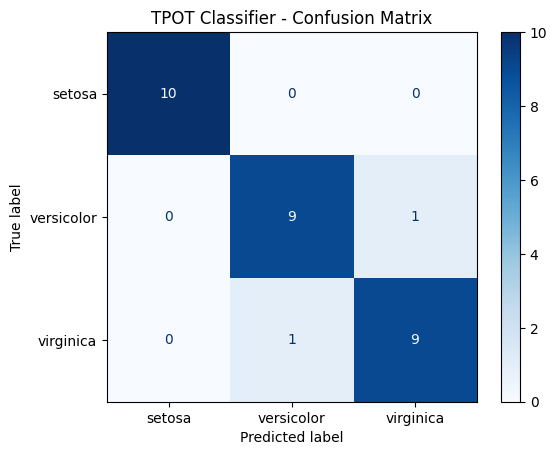

AttributeError: 'TPOTClassifier' object has no attribute 'export'

In [13]:
from tpot import TPOTClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load the Iris dataset ---
iris = load_iris(as_frame=True)
X = iris.data
y = iris.target

# --- Split data into training and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Initialize TPOT AutoML classifier ---
tpot = TPOTClassifier(
    generations=5,                # number of generations to evolve
    population_size=20,           # number of pipelines per generation
    random_state=42,
    max_time_mins=2,              # limit search to ~2 minutes
    n_jobs=1                     # use all CPU cores
)

# --- Fit the TPOT model ---
tpot.fit(X_train, y_train)

# --- Evaluate the best pipeline on test data ---
y_pred = tpot.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"✅ Test Accuracy: {acc:.3f}")
print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred, target_names=iris.target_names))

# --- Visualize confusion matrix ---
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=iris.target_names).plot(cmap="Blues")
plt.title("TPOT Classifier - Confusion Matrix")
plt.show()

# --- Export the discovered pipeline ---
tpot.export("tpot_iris_pipeline.py")
print("\n📁 Best pipeline saved to: tpot_iris_pipeline.py")
